In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rospy
import pickle

In [6]:
# Set up helper functions
from sensor_msgs.msg import JointState
from std_msgs.msg import Float64MultiArray
from geometry_msgs.msg import PoseStamped, WrenchStamped, TransformStamped, PointStamped
import rosbag
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def bag_loader(path, map_and_append_msg, topic_name, normalize = ''):
    bag = rosbag.Bag(path)
    num_obs = bag.get_message_count(topic_name)
    if num_obs == 0:
        topic_name = '/'+topic_name
        num_obs = bag.get_message_count(topic_name)
    print('Loading ros bag {}  with {} msgs on topic {}'.format(path, num_obs, topic_name))

    msgs = {}
    t = []
    for _, msg, t_ros in bag.read_messages(topics=[topic_name]):
        t.append(t_ros.to_sec())
        map_and_append_msg(msg, msgs)
    t = [tt-t[0] for tt in t]

    msgs_in_order = {}
    for key in msgs.keys():
        t_in_order, el_in_order = zip(*sorted(zip(t,msgs[key])))
        msgs_in_order[key] = np.array(el_in_order).T
    msgs_in_order['t'] = t_in_order
    
    if normalize != '':
        msgs_in_order[normalize] = (msgs_in_order[normalize].T-msgs_in_order[normlize][:,0]).T
        
    return msgs_in_order

def get_aligned_msgs(msgs1, msgs2):
    ''' 
    Select entries from msgs2 which occured most recently before msgs1
    '''
    aligned_msgs2 = {key:[] for key in msgs2.keys()}
    t2 = np.array(msgs2['t'])
    for t1 in msgs1['t']:
        last_before_t1 = np.where(t2<=t1)[0][-1] # find last time in t which is 
        for key in msgs2.keys():
            if key == 't': continue
            aligned_msgs2[key].append(msgs2[key][:,last_before_t1])

    for key in msgs2.keys():
        aligned_msgs2[key] = np.array(aligned_msgs2[key]).T
    
    return aligned_msgs2

def map_robot_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'force'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['force'].append(msg.effort)
    return prev_msgs

def map_pose(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ['pos']:
            prev_msgs[el] = []
    pt = msg.pose.position
    prev_msgs['pos'].append([pt.x, pt.y, pt.z])
    return prev_msgs

def map_joint_state(msg, prev_msgs):
    if len(prev_msgs) == 0:
        for el in ('pos', 'vel', 'torque'):
            prev_msgs[el] = []
    prev_msgs['pos'].append(msg.position)
    prev_msgs['vel'].append(msg.velocity)
    prev_msgs['torque'].append(msg.effort)
    return prev_msgs

Loading ros bag data/mpc_pivot_4_nocem.bag  with 429 msgs on topic /cartesian_impedance_example_controller/equilibrium_pose
Loading ros bag data/mpc_pivot_4_nocem.bag  with 342 msgs on topic /belief_obs
Loading ros bag data/mpc_pivot_5_cem5.bag  with 74 msgs on topic /cartesian_impedance_example_controller/equilibrium_pose
Loading ros bag data/mpc_pivot_5_cem5.bag  with 399 msgs on topic /belief_obs


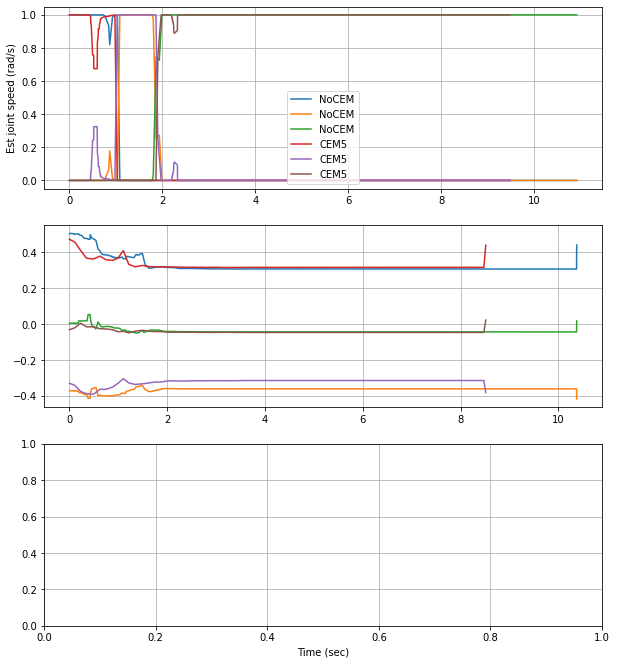

In [16]:
# Compare w/ and w/o stiffness model
bags = ['data/mpc_pivot_4_nocem.bag',
        'data/mpc_pivot_5_cem5.bag',]
#bags = ['data/mpc_pivot_6_cem10.bag',]
names = ['NoCEM', 'CEM5']

fig, axs = plt.subplots(3, figsize=(10,8))
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
cm = plt.get_cmap('tab10')
for sp, (bag, name) in enumerate(zip(bags, names)):
    col = cols.pop()
    ctrl_name = "/cartesian_impedance_example_controller/equilibrium_pose"
    msgs_ctrl = bag_loader(bag, map_pose, topic_name = ctrl_name)
    ctrl = msgs_ctrl['pos']
    t_ctrl = msgs_ctrl['t']
    
    msgs_bel = bag_loader(bag, map_joint_state, topic_name = 'belief_obs')
    bel = msgs_bel['pos']
    t_bel = msgs_bel['t']

    axs[0].plot(t_bel, bel.T, label=name)
    axs[1].plot(t_ctrl, ctrl.T, label=name)


axs[0].legend(loc='lower center')
for i in range(3): axs[i].grid(True)
#for i in range(3): axs[i].set_ylim((-0.15,0.2))
#for i in range(3): axs[i].set_xlim((-0.0,3.1))
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Est joint speed (rad/s)')
plt.subplots_adjust(top=1.2)
plt.savefig('joint_est_comp.pdf')
plt.show()

Loading ros bag data/valid_contact_online_stiff.bag  with 1397 msgs on topic /observer_jt
Loading ros bag data/valid_contact_online_stiff.bag  with 1248 msgs on topic /robot_state


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


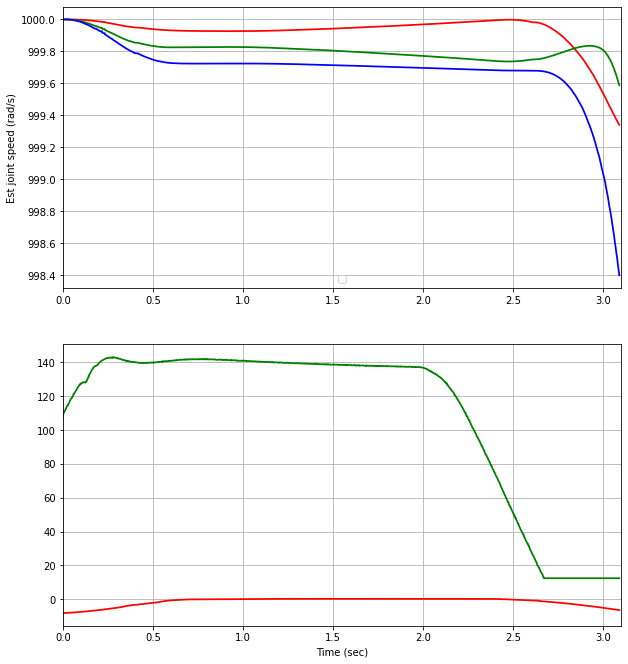

In [185]:
# Compare w/ and w/o stiffness model
bag = 'data/valid_contact_online_stiff.bag'

xrest = np.array(rospy.get_param('contact_1_rest'))
fig, axs = plt.subplots(2, figsize=(10,8))
cols = ['r', 'b', 'k', 'r:', 'b:', 'k:']
msgs2 = bag_loader(bag, map_joint_state, topic_name = 'observer_jt')
q_hat = msgs2['pos']
dq_hat = msgs2['vel']
stiff = msgs2['torque'][:3]
cont_pt = msgs2['torque'][3:]
t_hat = msgs2['t']

msgs = bag_loader(bag, map_robot_state, topic_name = 'robot_state')
msgs = get_aligned_msgs(msgs2, msgs)
q = msgs['pos']
dq = msgs['vel']
force = msgs['force']
t = msgs['t']


axs[0].plot(t_hat, stiff[0,:], color = 'r', linestyle = 'solid', linewidth=1.75)
axs[0].plot(t_hat, stiff[1,:], color = 'g', linestyle = 'solid', linewidth=1.75)
axs[0].plot(t_hat, stiff[2,:], color = 'b', linestyle = 'solid', linewidth=1.75)

disp = xrest-cont_pt
f = stiff.T@disp

axs[1].plot(t_hat, f[0,:], color = 'r', linestyle = 'solid', linewidth=1.75)
axs[1].plot(t_hat, force[2,:], color = 'g', linestyle = 'solid', linewidth=1.75)

axs[0].legend(loc='lower center')
for i in range(2): axs[i].grid(True)
for i in range(2): axs[i].set_xlim((-0.0,3.1))
plt.xlabel('Time (sec)')
axs[0].set(ylabel='Est joint speed (rad/s)')
plt.subplots_adjust(top=1.2)
plt.savefig('joint_est_comp.pdf')
plt.show()